In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as st
import math

In [2]:
# data path
name_head = './result/first/2023-06-04-20-17-14/'
save_path = name_head

# Data loading

In [3]:
# cnn_1 data
Acc_testdb = 100 * np.load(name_head + 'Acc_testdb_1.npy')
Acc_test_ = 100 * np.load(name_head + 'Acc_test_1.npy')
Acc_testpre = 100 * np.load(name_head + 'Acc_testpre_1.npy')
# cnn_2 data
Acc_testdb_2 = 100 * np.load(name_head + 'Acc_testdb_2.npy')
Acc_test__2 = 100 * np.load(name_head + 'Acc_test_2.npy')
Acc_testpre_2 = 100 * np.load(name_head + 'Acc_testpre_2.npy')

# calculate data threshold

In [4]:
def getIndexes(y_predict, y_data):
    run = len(y_data)//10
    y_predict = np.tile(y_predict,run)
    n = y_data.size
    SSE=((y_data-y_predict)**2).sum()
    MSE=SSE/n
    RMSE=np.sqrt(MSE)
    u = y_data.mean()
    SST=((y_data-u)**2).sum()
    SSR=SST-SSE
    R_square=SSR/SST
    return SSE, MSE, RMSE, R_square

def func(x, miu, theta):    
    return st.norm.cdf((x-miu)/theta)

def get_threshold_permodel(data,threshold=75):
    base =0.5
    Y1 = (np.array(data)/100-base)/(1-base)
    run = len(Y1)//10
    X1_ = np.arange(0,10)
    X1 = np.tile(X1_,run)
    # set the boundary of the fitting parameters
    # the first tuple is the lower bound of the parameter, and the second tuple is the upper bound of the parameter
    bounds = ([0, 0], [30., 13.])
    (miu,theta), pcov = curve_fit(func, X1,Y1,bounds=bounds,maxfev=5000)
    data_p = func(X1_,miu,theta)*100*(1-base) + base*100
    SSE, MSE, RMSE, R_square = getIndexes(data_p, np.array(data))
    return st.norm.ppf((threshold/100-base)/(1-base))*theta+miu,R_square


### pre-train data threshold

In [5]:
pre_train_permodel = np.array([Acc_testpre[:,:,0,2,:],Acc_testpre_2[:,:,4,6,:],Acc_testpre[:,:,4,2,:],Acc_testpre_2[:,:,0,6,:]])
pre_train_threshold_permodel = [[[get_threshold_permodel( i,threshold=80)[0] for i in j[0:] ]for j in k[0:] ]for k in pre_train_permodel]
pre_train_threshold_permodel_mean=np.mean(pre_train_threshold_permodel,axis=1)
pre_train_threshold_permodel_std=np.std(pre_train_threshold_permodel,axis=1)

/tmp/ipykernel_1758787/4070956684.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  R_square=SSR/SST
/home/lyumuyang/miniconda3/envs/pytorch/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:889: RuntimeWarning: divide by zero encountered in divide
  pcov = np.dot(VT.T / s**2, VT)


### conventional training & double training data threshold

In [6]:
con_train_permodel = np.array([Acc_test_[:,:,0,2,:],Acc_test__2[:,:,4,6,:],Acc_test_[:,:,4,2,:],Acc_test__2[:,:,0,6,:]])
con_train_threshold_permodel = [[[get_threshold_permodel( i,threshold=80)[0] for i in j[0:] ]for j in k[0:] ]for k in con_train_permodel]

db_train_permodel = np.array([Acc_testdb[:,:,0,2,:],Acc_testdb_2[:,:,4,6,:],Acc_testdb[:,:,4,2,:],Acc_testdb_2[:,:,0,6,:]]) 
db_train_threshold_permodel = [[[get_threshold_permodel( i,threshold=80)[0] for i in j[0:] ]for j in k[0:] ]for k in db_train_permodel]

/tmp/ipykernel_1758787/4070956684.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  R_square=SSR/SST
/home/lyumuyang/miniconda3/envs/pytorch/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:889: RuntimeWarning: overflow encountered in divide
  pcov = np.dot(VT.T / s**2, VT)


# draw the figures

In [7]:
# every 20 batches one session, the last batch of each session shows the threshold
conventional_training_permodel = np.array([np.array(con_train_threshold_permodel)[:,:,10*(i+1)-1] for i in range(10)])
double_training_permodel = np.array([np.array(db_train_threshold_permodel)[:,:,20*(i+1)-1] for i in range(10)])

conventional_training_permodel_mean = np.mean(conventional_training_permodel,axis=-1)
conventional_training_permodel_std = np.std(conventional_training_permodel,axis=-1)

double_training_permodel_mean = np.mean(double_training_permodel,axis=-1)
double_training_permodel_std = np.std(double_training_permodel,axis=-1)

### conventional training & double training threshold

In [ ]:
n=len(pre_train_threshold_permodel[0])
n

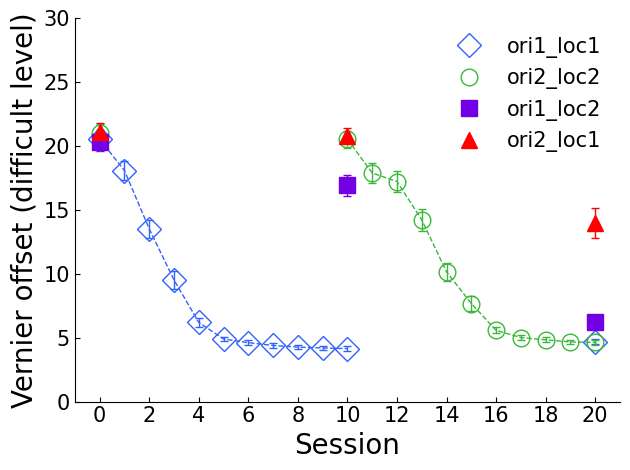

In [9]:
plt.figure(facecolor='white')

ax = plt.axes()
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in')

# color
blue=(49/255,98/255,254/255)
purple=(115/255,0,229/255)
green=(57/255,184/255,57/255)
red=(255/255,0,0)

# label
plt.plot([0], 100,
                         marker='D', markeredgecolor=blue, linestyle='none', color=blue, linewidth=1, markerfacecolor='none', label='ori1_loc1', markersize=12)
plt.plot([0], 100, 
                         marker='o', markeredgecolor=green, linestyle='none', color=green, linewidth=1, markerfacecolor='none', label='ori2_loc2', markersize=12)
plt.plot([0], 100, 
                        marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, label='ori1_loc2', markersize=12)
plt.plot([0], 100, 
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, label='ori2_loc1', markersize=12)


plt.errorbar(np.arange(0,11,1), 
                         np.concatenate(([pre_train_threshold_permodel_mean[0,-1]],conventional_training_permodel_mean[:,0])), 
                         yerr=np.concatenate(([pre_train_threshold_permodel_std[0,-1]/math.sqrt(n)],conventional_training_permodel_std[:,0]/math.sqrt(n))),
                         marker='D', markeredgecolor=blue, linestyle='--', color=blue, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=blue)

plt.errorbar([20], double_training_permodel_mean[-1,0], 
                         yerr=double_training_permodel_std[-1,0]/math.sqrt(n),
                         marker='D', markeredgecolor=blue, linestyle='none', color=blue, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=blue)

plt.errorbar([0], pre_train_threshold_permodel_mean[1,-1], 
                         yerr=pre_train_threshold_permodel_std[1,-1]/math.sqrt(n),
                         marker='o', markeredgecolor=green, linestyle='none', color=green, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=green)

plt.errorbar(np.arange(10,21,1), 
                         np.concatenate(([conventional_training_permodel_mean[-1,1]],double_training_permodel_mean[:,1])), 
                         yerr=np.concatenate(([conventional_training_permodel_std[-1,1]/math.sqrt(n)],double_training_permodel_std[:,1]/math.sqrt(n))),
                         marker='o', markeredgecolor=green, linestyle='--', color=green, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=green)

plt.errorbar([0], pre_train_threshold_permodel_mean[2,-1], 
                         yerr=pre_train_threshold_permodel_std[2,-1]/math.sqrt(n),
                         marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, markersize=12, capsize=3, ecolor=purple)

plt.errorbar([10], conventional_training_permodel_mean[-1,2], 
                        yerr=conventional_training_permodel_std[-1,2]/math.sqrt(n),
                        marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, markersize=12, capsize=3, ecolor=purple)

plt.errorbar([20], double_training_permodel_mean[-1,2], 
                         yerr=double_training_permodel_std[-1,2]/math.sqrt(n),
                         marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, markersize=12, capsize=3, ecolor=purple)

plt.errorbar([0], pre_train_threshold_permodel_mean[3,-1], 
                         yerr=pre_train_threshold_permodel_std[3,-1]/math.sqrt(n),
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, markersize=12, capsize=3, ecolor=red)

plt.errorbar([10], conventional_training_permodel_mean[-1,3], 
                         yerr=conventional_training_permodel_std[-1,3]/math.sqrt(n),
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, markersize=12, capsize=3, ecolor=red)

plt.errorbar([20], double_training_permodel_mean[-1,3], 
                         yerr=double_training_permodel_std[-1,3]/math.sqrt(n),
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, markersize=12, capsize=3, ecolor=red)

plt.xlabel('Session', fontsize=20)
plt.ylabel('Vernier offset (difficult level)', fontsize=20)
plt.ylim(0,30)
plt.legend(frameon=False, fontsize=15)
plt.tight_layout()

plt.savefig(save_path+'exp4_threshold_100.svg',dpi=300)

plt.show()

### conventional training & double training improvement

In [10]:
ori1_loc1_o = pre_train_threshold_permodel_mean[0,-1]
ori2_loc2_o = pre_train_threshold_permodel_mean[1,-1]
ori1_loc2_o = pre_train_threshold_permodel_mean[2,-1]
ori2_loc1_o = pre_train_threshold_permodel_mean[3,-1]

ori1_loc1_c = conventional_training_permodel_mean[-1,0]
ori2_loc2_c = conventional_training_permodel_mean[-1,1]
ori1_loc2_c = conventional_training_permodel_mean[-1,2]
ori2_loc1_c = conventional_training_permodel_mean[-1,3]

ori1_loc1_db = double_training_permodel_mean[-1,0]
ori2_loc2_db = double_training_permodel_mean[-1,1]
ori1_loc2_db = double_training_permodel_mean[-1,2]
ori2_loc1_db = double_training_permodel_mean[-1,3]

# permodel
ori1_loc1_o_permodel = np.array(pre_train_threshold_permodel)[0,:,-1]
ori2_loc2_o_permodel = np.array(pre_train_threshold_permodel)[1,:,-1]
ori1_loc2_o_permodel = np.array(pre_train_threshold_permodel)[2,:,-1]
ori2_loc1_o_permodel = np.array(pre_train_threshold_permodel)[3,:,-1]

ori1_loc1_c_permodel = np.array(conventional_training_permodel)[-1,0,:]
ori2_loc2_c_permodel = np.array(conventional_training_permodel)[-1,1,:]
ori1_loc2_c_permodel = np.array(conventional_training_permodel)[-1,2,:]
ori2_loc1_c_permodel = np.array(conventional_training_permodel)[-1,3,:]

ori1_loc1_db_permodel = np.array(double_training_permodel)[-1,0,:]
ori2_loc2_db_permodel = np.array(double_training_permodel)[-1,1,:]
ori1_loc2_db_permodel = np.array(double_training_permodel)[-1,2,:]
ori2_loc1_db_permodel = np.array(double_training_permodel)[-1,3,:]

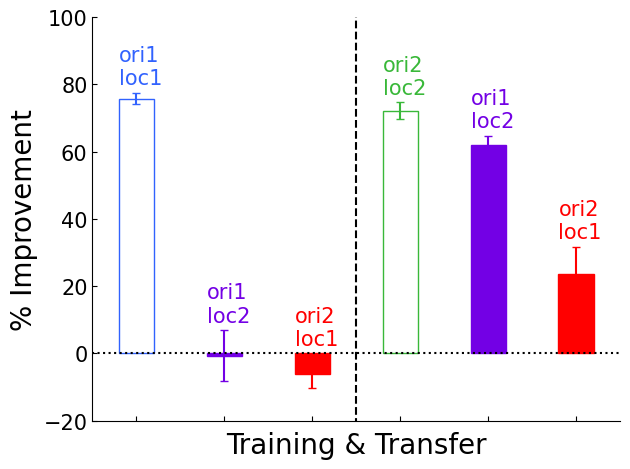

In [11]:
# plt.style.use('classic')
plt.style.use('default')

plt.figure(facecolor='white')

ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15,direction='in')

# color
blue=(49/255,98/255,254/255)
purple=(115/255,0,229/255)
green=(57/255,184/255,57/255)
red=(255/255,0,0)

y=[-(ori1_loc1_c_permodel-ori1_loc1_o_permodel)/ori1_loc1_o_permodel*100,\
                            -(ori1_loc2_c_permodel-ori1_loc2_o_permodel)/ori1_loc2_o_permodel*100,\
                                -(ori2_loc1_c_permodel-ori2_loc1_o_permodel)/ori2_loc1_o_permodel*100,\

                                    -(ori2_loc2_db_permodel-ori2_loc2_o_permodel)/ori2_loc2_o_permodel*100,\
                                        -(ori1_loc2_db_permodel-ori1_loc2_o_permodel)/ori1_loc2_o_permodel*100,\
                                            -(ori2_loc1_db_permodel-ori2_loc1_o_permodel)/ori2_loc1_o_permodel*100,\
                                    ]

y_mean = np.mean(y,axis=-1)
y_err = np.std(y,axis=-1)

label = ["ori1\nloc1","ori1\nloc2","ori2\nloc1","ori2\nloc2","ori1\nloc2","ori2\nloc1",]
edgecolor = [blue,purple,red,green,purple,red]
bar=plt.bar(np.arange(0,6,1),y_mean,color=['white',purple,red,'white',purple,red],
                                    edgecolor=[blue,purple,red,green,purple,red],
                                    width= 0.4)

# Add error bars with matching colors
for i in range(len(bar)):
    plt.errorbar(i, y_mean[i], yerr=y_err[i]/math.sqrt(n), fmt='none', ecolor=edgecolor[i], capsize=3)

for i in [0,1,2,3,4,5]:
    if y_mean[i]+y_err[i]/math.sqrt(n)>0:
        plt.text(x = i-0.2, y = y_mean[i]+y_err[i]/math.sqrt(n)+2.5,s = label[i],color = edgecolor[i], fontsize=15)
    else:
        plt.text(x = i-0.2, y = 0+2.5,s = label[i],color = edgecolor[i], fontsize=15)


plt.hlines([0],xmin=-0.5,xmax=5.5,linestyle=':',color='black')
plt.vlines([2.5],ymin=-160,ymax=100,linestyle='--',color='black')

plt.xticks(np.arange(0,6,1),[],)

plt.xlim([-0.5,5.5])
plt.ylim([-20,100])

plt.xlabel('Training & Transfer', fontsize=20)
plt.ylabel('% Improvement', fontsize=20)

# plt.legend()
plt.tight_layout()
plt.savefig(save_path+'exp4_improvement_100.svg',dpi=300)

plt.show()

### conventional training threshold

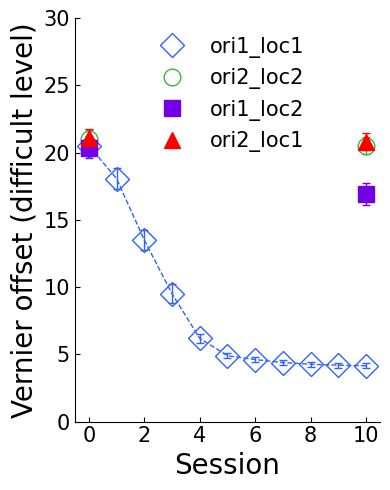

In [12]:
plt.figure(facecolor='white', figsize=(4,5))

ax = plt.axes()
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15,direction='in')

# color
blue=(49/255,98/255,254/255)
purple=(115/255,0,229/255)
green=(57/255,184/255,57/255)
red=(255/255,0,0)

# label
plt.plot([0], 100,
                         marker='D', markeredgecolor=blue, linestyle='none', color=blue, linewidth=1, markerfacecolor='none', label='ori1_loc1', markersize=12)
plt.plot([0], 100, 
                         marker='o', markeredgecolor=green, linestyle='none', color=green, linewidth=1, markerfacecolor='none', label='ori2_loc2', markersize=12)
plt.plot([0], 100, 
                        marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, label='ori1_loc2', markersize=12)
plt.plot([0], 100, 
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, label='ori2_loc1', markersize=12)

plt.errorbar(np.arange(0,11,1), 
                         np.concatenate(([pre_train_threshold_permodel_mean[0,-1]],conventional_training_permodel_mean[:,0])), 
                         yerr=np.concatenate(([pre_train_threshold_permodel_std[0,-1]],conventional_training_permodel_std[:,0]))/math.sqrt(n),
                         marker='D', markeredgecolor=blue, linestyle='--', color=blue, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=blue)

plt.errorbar([0], pre_train_threshold_permodel_mean[1,-1], 
                         yerr=pre_train_threshold_permodel_std[1,-1]/math.sqrt(n),
                         marker='o', markeredgecolor=green, linestyle='none', color=green, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=green)

plt.errorbar([10], conventional_training_permodel_mean[-1,1], 
                        yerr=conventional_training_permodel_std[-1,1]/math.sqrt(n),
                        marker='o', markeredgecolor=green, linestyle='--', color=green, linewidth=1, markerfacecolor='none', markersize=12, capsize=3, ecolor=green)

plt.errorbar([0], pre_train_threshold_permodel_mean[2,-1], 
                         yerr=pre_train_threshold_permodel_std[2,-1]/math.sqrt(n),
                         marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, markersize=12, capsize=3, ecolor=purple)

plt.errorbar([10], conventional_training_permodel_mean[-1,2], 
                        yerr=conventional_training_permodel_std[-1,2]/math.sqrt(n),
                        marker='s', markeredgecolor=purple, linestyle='none', linewidth=1, markerfacecolor=purple, markersize=12, capsize=3, ecolor=purple)

plt.errorbar([0], pre_train_threshold_permodel_mean[3,-1], 
                         yerr=pre_train_threshold_permodel_std[3,-1]/math.sqrt(n),
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, markersize=12, capsize=3, ecolor=red)

plt.errorbar([10], conventional_training_permodel_mean[-1,3], 
                         yerr=conventional_training_permodel_std[-1,3]/math.sqrt(n),
                         marker='^', markeredgecolor=red, linestyle='none', linewidth=1, markerfacecolor=red, markersize=12, capsize=3, ecolor=red)

plt.xlabel('Session', fontsize=20)
plt.ylabel('Vernier offset (difficult level)', fontsize=20)
plt.ylim(0,30)
plt.legend(frameon=False, fontsize=15)
plt.tight_layout()

plt.savefig(save_path+'exp1_threshold_100.svg',dpi=300)

plt.show()

### conventional training improvement

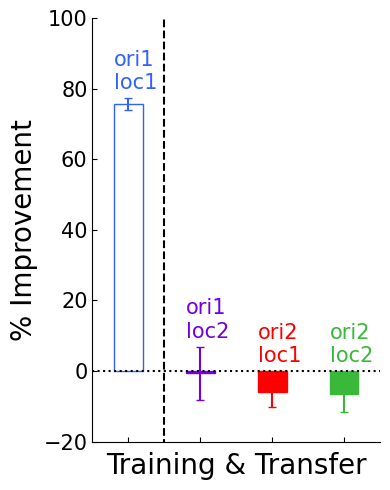

In [13]:
# plt.style.use('classic')
plt.style.use('default')

plt.figure(facecolor='white', figsize=(4,5))
# plt.errorbar(X1, Y0, fmt="none", yerr=20, xerr=0, ecolor='r') 

ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15,direction='in')

# color
blue=(49/255,98/255,254/255)
purple=(115/255,0,229/255)
green=(57/255,184/255,57/255)
red=(255/255,0,0)

y=[-(ori1_loc1_c_permodel-ori1_loc1_o_permodel)/ori1_loc1_o_permodel*100,\
                            -(ori1_loc2_c_permodel-ori1_loc2_o_permodel)/ori1_loc2_o_permodel*100,\
                            -(ori2_loc1_c_permodel-ori2_loc1_o_permodel)/ori2_loc1_o_permodel*100,\
                                -(ori2_loc2_c_permodel-ori2_loc2_o_permodel)/ori2_loc2_o_permodel*100,\
                                    
                                    ]

y_mean = np.mean(y,axis=-1)
y_err = np.std(y,axis=-1)

label = ["ori1\nloc1","ori1\nloc2","ori2\nloc1","ori2\nloc2","ori1_loc2","ori2_loc2","ori2_loc1"]
edgecolor=[blue,purple,red,green,red,purple,green]
bar=plt.bar(np.arange(0,4,1),y_mean,color=['white',purple,red,green,red,purple,green],
                                    edgecolor=edgecolor,
                                    width= 0.4)

# Add error bars with matching colors
for i in range(len(bar)):
    plt.errorbar(i, y_mean[i], yerr=y_err[i]/math.sqrt(n), fmt='none', ecolor=edgecolor[i], capsize=3)

for i in [0,1,2,3]:
    if y_mean[i]+y_err[i]/math.sqrt(n)>0:
            plt.text(x = i-0.2, y = y_mean[i]+y_err[i]/math.sqrt(n)+2.5,s = label[i],color = edgecolor[i], fontsize=15) 
    else:
        plt.text(x = i-0.2, y = 0+2.5,s = label[i],color = edgecolor[i], fontsize=15)

plt.hlines([0],xmin=-0.5,xmax=3.5,linestyle=':',color='black')
plt.vlines([0.5],ymin=-160,ymax=100,linestyle='--',color='black')

plt.xticks(np.arange(0,7,1),[],)

plt.xlim([-0.5,3.5])
plt.ylim([-20,100])

plt.xlabel('Training & Transfer', fontsize=20)
plt.ylabel('% Improvement', fontsize=20)

# plt.legend()
plt.tight_layout()
plt.savefig(save_path+'exp1_improvement_100.svg',dpi=300)

plt.show()